Initialize

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["KERAS_BACKEND"] = "torch"   # Must be called before importing keras
import keras
import torch
from scipy import stats
seed = 100

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Testing GPU access
## Using pytorch because jax won't work with cuda on Windows 11, and the tensorflow installation didn't recognize the gpu
## However, pytorch is MUCH slower when all use the GPU.
print("Is CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.get_device_name(0))

Is CUDA available: True
Current device: NVIDIA GeForce GTX 1660 Ti


Import data and concatenate

In [4]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [5]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [6]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

EDA

Mean rating: 2.462406015037594
Standard deviation of rating: 0.7309589441336174


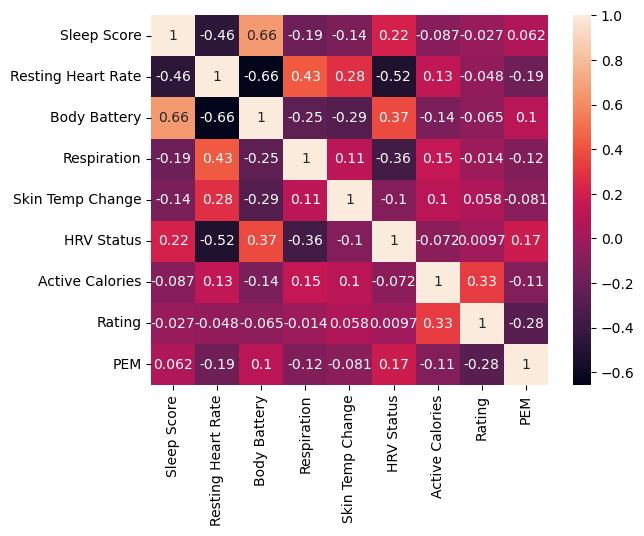

In [7]:
dfp = df.to_pandas()
matrix = dfp.iloc[:, 1:10].corr()
sns.heatmap(matrix, annot=True)

# Check average to get sense of meaningfully close predictions
print(f"Mean rating: {np.mean(dfp.iloc[:, 8])}")
print(f"Standard deviation of rating: {np.std(dfp.iloc[:, 8])}")

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Standardize and split data

In [8]:
scaler = StandardScaler()
dfp.iloc[:, 1:7] = scaler.fit_transform(dfp.iloc[:, 1:7])

# Initial split between train, validation, and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.3, random_state=seed)
dfp_test, dfp_val = train_test_split(dfp_test, test_size=0.5, random_state=seed)
X_train = dfp_train.iloc[:, 0:6]
y_train = dfp_train.iloc[:, 7]
X_val = dfp_val.iloc[:, 0:6]
y_val = dfp_val.iloc[:, 7]
X_test = dfp_test.iloc[:, 0:6]
y_test = dfp_test.iloc[:, 7]

**PART ONE: Create regression model**

In [9]:
## Each hyperparameter, including the number of layers and nodes, whether to use L2 regularization on each layer, 
## the bactch size, the dropout rate, the learning rate, and the L2 penalty was determined through a manual grid search.
## After finding a 'best' model that was weak, I tried changing the validation metric to the MSE and (correctly) 
## changing the early stopping to revert to the best model. However, these changes decreased the model's predictive
## abilityon the test set, suggesting overfitting to the validation set.


keras.utils.set_random_seed(seed)
input_shape = (6,)

# Set hyperparamters
batch = 32  # best results at both 32 and 64, worse in-between. Sticking with default
nodes = 26  # Tested different types of funneling
drop_rate = 0.5  
learn = 0.002  
pen = 0.01 

model = keras.Sequential(
    [ keras.layers.Input(shape = input_shape),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer1"),
        keras.layers.Dropout(drop_rate, name = "dropout1"),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer2"),
        keras.layers.Dropout(drop_rate, name = "dropout2"),
        keras.layers.Dense(nodes, activation="relu",  
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer3"),
        keras.layers.Dense(1, activation = "linear", 
                           kernel_regularizer=keras.regularizers.L2(l2=pen), 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "output")])
# model.summary()  # Uncomment to print architecture on screen

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learn),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")])

callbacks = [keras.callbacks.EarlyStopping(monitor="val_mae", patience=100, 
                                           restore_best_weights=False)]  # Wrong setting but better model

results = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 1000, 
    verbose = 0,
    callbacks=callbacks,
    batch_size = batch)

print(f'Best validation MAE: {round(min(results.history['val_mae']), 3)}')

test_metrics = model.evaluate(X_test, y_test, return_dict = True)
print(f'Test MAE: {round(test_metrics['mae'], 3)}')

model.save("final_model_rating.keras")  # save final model
model_final = keras.saving.load_model("final_model_rating.keras")  # reload
predictions = model_final.predict(X_test) # make predictions

Best validation MAE: 0.533
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4869 - mae: 0.5994
Test MAE: 0.596
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Plot training and validation loss and metric

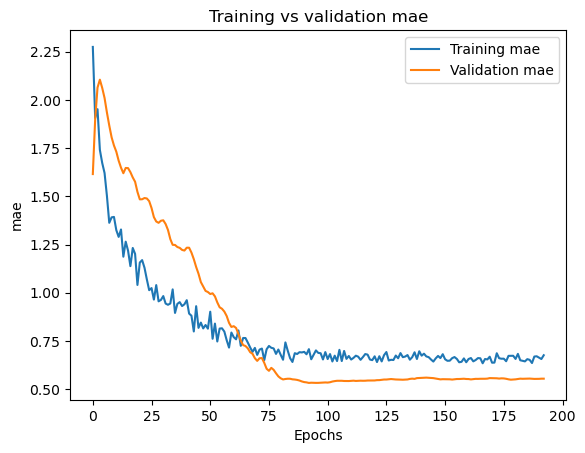

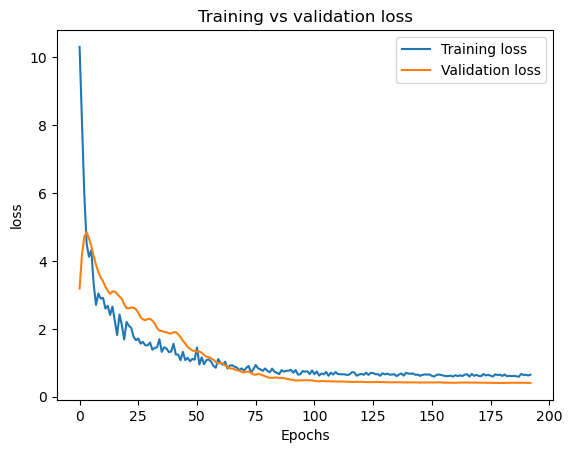

In [10]:
## Oddly, the validation metric and loss are consistently better than the training results: definitely not overfitting!
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Training vs validation {metric}')
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(results, 'mae')

# Plot loss
plot_metrics(results, 'loss')

Checking correlation of predictions to actual results, using test set 

Correlation between observations and predictions: 0.12
Standard deviation of MAE: 0.32


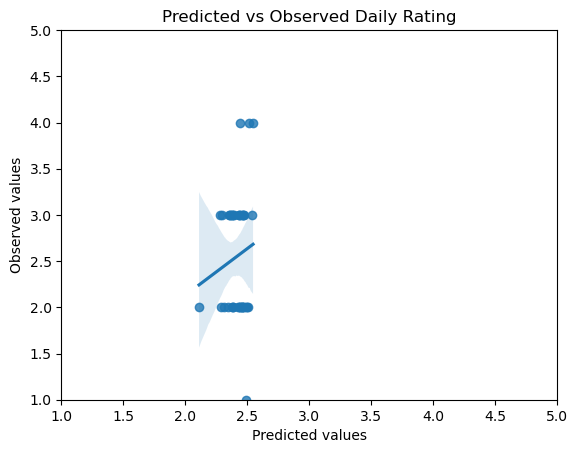

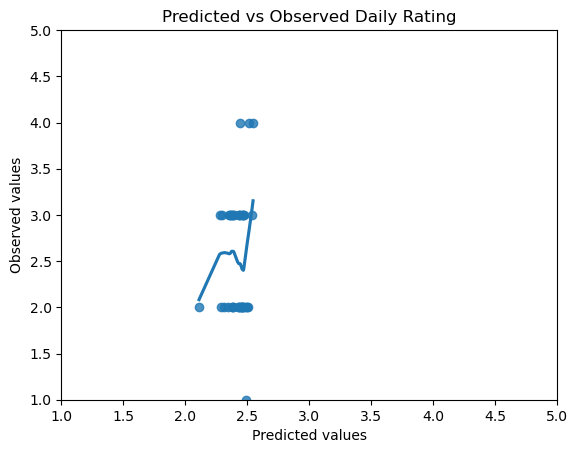

In [11]:
# Correlation and standard deviation of the errors
print(f'Correlation between observations and predictions: {round(np.corrcoef(y_test, predictions.flatten())[1][0], 2)}') 
print(f'Standard deviation of MAE: {round(np.std(np.absolute(np.subtract(y_test, predictions.flatten()))), 2)}')

# Plotting lowess and linear regression lines, with 95% confidence interval for latter
sns.regplot(y = y_test, x = predictions)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(1, 5)
plt.ylim(1,5)
plt.show()

sns.regplot(y = y_test, x = predictions, lowess = True)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(1, 5)
plt.ylim(1,5)
plt.show()

**Discussion:** This discussion is based on the test set (n=40), which makes the conclusions conservative. The lowest (i.e. best) MAE on the validation set was 0.436. However, the best model's MAE on the test set was 0.677, and the standard deviation of the test MAE was 0.4. Thus, on average, the prediction will be within 1.1 of the true rating ~68% of the time and within 1.5 rating points ~95% of the time - on a scale of 5. The correlation between predictions and true ratings was 0.37. 

However, the outcome is ordinal, which complicates interpretation. For example, the reported rating actually represents a range of 0.5 in either direction (e.g. 0.5-1.5, 1.5-2.5, ...). Thus, a lower bound on the inaccuracy is that, on average, the prediction will be somewhere within 0.6 of the true rating ~68% of the time and within 1.0 rating points ~95% of the time. However, the true rating on a continuous line might lie in the opposite direction from the predicted one, which inevitably reduces this improvement in accuracy by an unknown amount. That is, a rating of 4 might really represent a perceived rating of 4.3, while the model might predict 3.6.

Further - and worse - the model produced a highly circumscribed range of predictions on the test set (~2.3 to ~2.65), meaning that its accuracy is based on the fact that most days were rated 2 or 3, so it always predicts close to the midpoint, 2.5. It clearly does unacceptably on the best and worst days.

(With seed = 100 instead of 123, the test MAE and its standard deviation were lower but so was the correlation. Ultimately, it suffered from the same problem with always predicting close to the average.)

Taken together, these results suggest that the model might appear to be moderately accurate and reliable by some measures, but in practice it would not reliably register important changes.

(I tested the final model on the full dataset but got very similar results. I suspect that a) it's overfitting to the validation set due to too few records and b) there's actually no strong signal.)